In [99]:
import os
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as scikit
import OutlierDetection as out_det
import preprocessing as prepro
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing as preproc
from sklearn import compose
from sklearn import pipeline as ppline
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [6]:
dirname = os.getcwd()
dataset_path = os.path.join(dirname, 'data/adult_dataset/adult.test')

In [7]:
dataframe = pd.read_csv(dataset_path, header=None, skiprows=1,
                        names=["Age","Work Class","Final Weight","Education","Education Num", "Marital Status","Occupation","Relationship","Race","Sex","Capital Gain","Capital Loss","Hours Per Week","Native Country","Income Class"])
dataframe.head(5)

,Age,Work Class,Final Weight,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours Per Week,Native Country,Income Class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [8]:
print(dataframe.shape)
dataframe.describe()

(16281, 15)


,Age,Final Weight,Education Num,Capital Gain,Capital Loss,Hours Per Week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


### Cleaning string values from any leading or trailing whitespaces:

In [9]:
dataframe = dataframe.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### Describing the features based on type

In [10]:
numerical_features = dataframe.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 6 numerical features: 

['Age', 'Final Weight', 'Education Num', 'Capital Gain', 'Capital Loss', 'Hours Per Week']


In [11]:
categorical_features = dataframe.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 9 categorical features: 

['Work Class', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native Country', 'Income Class']


In [12]:
for col in categorical_features:
    print(f"Unique values in the '{col}' column:", '\n')
    print(dataframe[col].value_counts(), '\n')

Unique values in the 'Work Class' column: 

Private             11210
Self-emp-not-inc     1321
Local-gov            1043
?                     963
State-gov             683
Self-emp-inc          579
Federal-gov           472
Without-pay             7
Never-worked            3
Name: Work Class, dtype: int64 

Unique values in the 'Education' column: 

HS-grad         5283
Some-college    3587
Bachelors       2670
Masters          934
Assoc-voc        679
11th             637
Assoc-acdm       534
10th             456
7th-8th          309
Prof-school      258
9th              242
12th             224
Doctorate        181
5th-6th          176
1st-4th           79
Preschool         32
Name: Education, dtype: int64 

Unique values in the 'Marital Status' column: 

Married-civ-spouse       7403
Never-married            5434
Divorced                 2190
Widowed                   525
Separated                 505
Married-spouse-absent     210
Married-AF-spouse          14
Name: Marital Status

### Demonstrating that the Education Num and Education columns are identical

In [13]:
setOfEducationPairs = set(zip(dataframe['Education Num'],dataframe['Education']))
print(setOfEducationPairs)

{(6, '10th'), (2, '1st-4th'), (15, 'Prof-school'), (5, '9th'), (14, 'Masters'), (16, 'Doctorate'), (8, '12th'), (4, '7th-8th'), (7, '11th'), (9, 'HS-grad'), (3, '5th-6th'), (1, 'Preschool'), (11, 'Assoc-voc'), (10, 'Some-college'), (12, 'Assoc-acdm'), (13, 'Bachelors')}


### Removing 'Education' as we will use it as ordinal data

In [14]:
dataframe = dataframe.drop('Education', axis='columns')

### Visualizing the features

<AxesSubplot:ylabel='Frequency'>

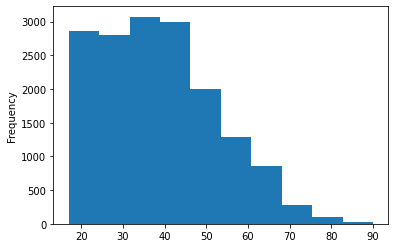

In [15]:
dataframe["Age"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

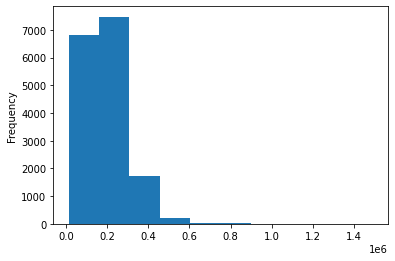

In [16]:
dataframe["Final Weight"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

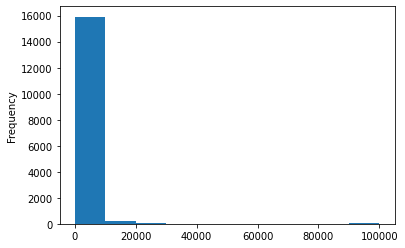

In [17]:
dataframe["Capital Gain"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

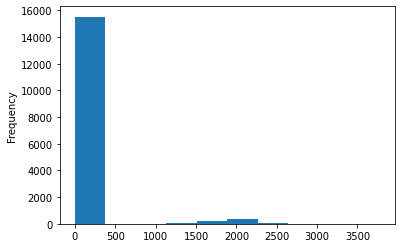

In [18]:
dataframe["Capital Loss"].plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

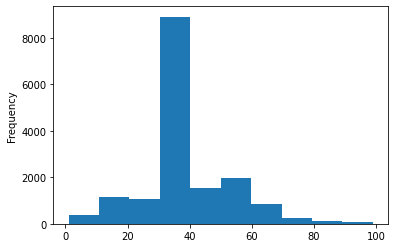

In [19]:
dataframe["Hours Per Week"].plot(kind="hist")

In [20]:
#Prepare a dictionary with all the testing dataframes
dfs_touse = {}

## Working with missing values

### Replacing missing values described as '?' with NaN

In [21]:
dataframe = dataframe.replace('?',np.nan)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             16281 non-null  int64 
 1   Work Class      15318 non-null  object
 2   Final Weight    16281 non-null  int64 
 3   Education Num   16281 non-null  int64 
 4   Marital Status  16281 non-null  object
 5   Occupation      15315 non-null  object
 6   Relationship    16281 non-null  object
 7   Race            16281 non-null  object
 8   Sex             16281 non-null  object
 9   Capital Gain    16281 non-null  int64 
 10  Capital Loss    16281 non-null  int64 
 11  Hours Per Week  16281 non-null  int64 
 12  Native Country  16007 non-null  object
 13  Income Class    16281 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


### Counting the missing values

In [22]:
columnsWithMissing = dataframe.isnull().sum() > 0

print("Columns with missing values: ")
dataframe.isnull().sum()[columnsWithMissing]

Columns with missing values: 


Work Class        963
Occupation        966
Native Country    274
dtype: int64

In [23]:
#Make one dataframe with dropped missing values
dfs_touse['df_dropmiss'] = dataframe.dropna()
dfs_touse['df_withmiss'] = dataframe

### Encoding categorical features

In [24]:
#Define function
def encode_cat_columns(dataframe: pd.DataFrame):
    #One Hot Encode all categorical values without missing data
    dataframe = pd.get_dummies(dataframe, columns=["Marital Status", "Relationship", "Race"], drop_first=True)
    
    #Encode the target column
    dataframe = dataframe.replace({'Income Class': {"<=50K.": 0, ">50K.":1}})
    
    #Encode the 'Sex' column
    dataframe = dataframe.replace({'Sex': {'Male':0, 'Female':1}})
    
    return dataframe

In [25]:
#Encode features in all datasets
for key,value in dfs_touse.items():
    dfs_touse[key] = encode_cat_columns(value)

### Filling the missing values

In [26]:
#Define function
def fill_missing_knn(dataframe: pd.DataFrame, columns: list = ['Work Class','Occupation','Native Country']):  
    #Save the unique values
    unique_val = {}
    for col in columns:
        x = dataframe[col].unique()
        unique_val[col] = x[~pd.isnull(x)]
    
    #Ordinally encode the columns with missing data so that they can be inversed after filling
    ordinal_enc = OrdinalEncoder()
    dataframe[columns] = ordinal_enc.fit_transform(dataframe[columns])
    
    #Fill the missing values using KNN
    knn_imputer = KNNImputer(n_neighbors=1)
    results = knn_imputer.fit_transform(dataframe)

    column_names = dataframe.columns
    new_dataframe = pd.DataFrame(results, columns=column_names)
    
    #Revert the ordinally encoded columns back to string values
    new_dataframe[columns] = ordinal_enc.inverse_transform(new_dataframe[columns])
    
    #Check if values have been maintained through conversion
    for col in columns:
        if not prepro.list_compare(unique_val[col], new_dataframe[col].unique().tolist()):
            print(f"Error while filling in missing values: Unique values in column '{col}' have changed.")
            print(unique_val[col])
            print(new_dataframe[col].value_counts())
            return dataframe
    
    return new_dataframe

In [27]:
#Fill the missing values in the specific dataset
dfs_touse['df_withmiss'] = fill_missing_knn(dfs_touse['df_withmiss'])

In [28]:
#One Hot Encode the rest of the categorical features in all datasets
for key,value in dfs_touse.items():
    dfs_touse[key] = pd.get_dummies(value, columns=['Work Class','Occupation','Native Country'], drop_first=True)

### Detecting outliers 

#### Using IQR, Z-Score and Modified Z-Score

In [29]:
outlierCounts = {}

for key,value in dfs_touse.items():
    tempCounts = {}
    print(f"{key:26}","IQR ZScore ModZScore", '\n')
    for col in numerical_features:
        outliersIQR = out_det.indicies_of_outliers(value[col])
        outliersZScore = out_det.outliers_z_score(value[col])
        outliersModZScore = out_det.outliers_modified_z_score(value[col])
        tempCounts[col] = (outliersIQR, outliersZScore, outliersModZScore)
        print(f"Column '{col:14}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
    outlierCounts[key] = tempCounts
    print()

df_dropmiss                IQR ZScore ModZScore 

Column 'Age           ':    57     57        12
Column 'Final Weight  ':   426    149       167
Column 'Education Num ':    98     98       694
Column 'Capital Gain  ':  1252    112         0
Column 'Capital Loss  ':   713    696         0
Column 'Hours Per Week':  3946    221      2624

df_withmiss                IQR ZScore ModZScore 

Column 'Age           ':    73     49        14
Column 'Final Weight  ':   471    160       185
Column 'Education Num ':   596    111       777
Column 'Capital Gain  ':  1323    116         0
Column 'Capital Loss  ':   763    746         0
Column 'Hours Per Week':  4488    221      3012



#### Visualizing Hours Per Week outliers

<AxesSubplot:ylabel='Frequency'>

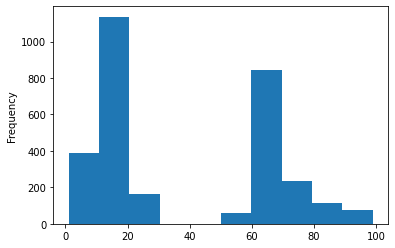

In [30]:
outliers = out_det.outliers_modified_z_score(dataframe["Hours Per Week"])
dataframe["Hours Per Week"].iloc[outliers.tolist()].plot(kind="hist")

#### Attempting to log scale Hours Per Week in an attempt to reduce outlier count

                                   IQR ZScore ModZScore 

Column 'Hours Per Week        ':  4488    221      3012
Column 'Hours Per Week (Log10)':  4496    389      3248


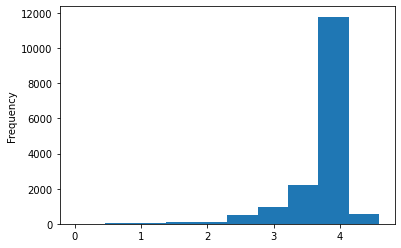

In [31]:
col = "Exp10 Scaled Hours Per Week"

dataframe[col] = [np.log(x) for x in dataframe["Hours Per Week"]]

outliersIQR = out_det.indicies_of_outliers(dataframe[col])
outliersZScore = out_det.outliers_z_score(dataframe[col])
outliersModZScore = out_det.outliers_modified_z_score(dataframe[col])

oldIQR, oldZScore, oldModZScore = outlierCounts.get('df_withmiss').get('Hours Per Week')
print(" " * 34,"IQR ZScore ModZScore", '\n')
print(f"Column '{'Hours Per Week':22}': {len(oldIQR):5} {len(oldZScore):6} {len(oldModZScore):9}")
print(f"Column '{'Hours Per Week (Log10)':22}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
dataframe[col].plot(kind="hist")

dataframe = dataframe.drop(columns=[col])

### Prepare dataframes with dropped outliers (using ZScore)

In [32]:
newDfs = {}
for key,value in dfs_touse.items():
    newVal = value.copy()
    outRem = out_det.OutlierRemover('ZScore')
    newVal[numerical_features] = outRem.fit_transform(newVal[numerical_features])
    newVal = newVal.dropna()
    newDfs[key + '_dropoutl'] = newVal
dfs_touse.update(newDfs)

### Check out the resulting datasets

In [33]:
for key,value in dfs_touse.items():
    print(key)
    value.info()

df_dropmiss
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15060 entries, 0 to 16280
Data columns (total 81 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Age                                        15060 non-null  int64
 1   Final Weight                               15060 non-null  int64
 2   Education Num                              15060 non-null  int64
 3   Sex                                        15060 non-null  int64
 4   Capital Gain                               15060 non-null  int64
 5   Capital Loss                               15060 non-null  int64
 6   Hours Per Week                             15060 non-null  int64
 7   Income Class                               15060 non-null  int64
 8   Marital Status_Married-AF-spouse           15060 non-null  uint8
 9   Marital Status_Married-civ-spouse          15060 non-null  uint8
 10  Marital Status_Married-spouse-abse

## Handle class imbalance

In [34]:
#Check out the level of imbalance in the original dataset
print('Counts of rows by class:')
print(dataframe['Income Class'].value_counts())

Counts of rows by class:
<=50K.    12435
>50K.      3846
Name: Income Class, dtype: int64


In [35]:
#Define functions
def upsample(dataframe: pd.DataFrame):
    #Count classes
    counts = dataframe['Income Class'].value_counts()
    count_class_0 = counts.loc[0]
    count_class_1 = counts.loc[1]
    
    #Split dataframe
    df_class_0 = dataframe[dataframe['Income Class'] == 0]
    df_class_1 = dataframe[dataframe['Income Class'] == 1]
    
    #Check which class has lower count
    if count_class_0 > count_class_1:
        #1 is minority class
        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        
        #Concat results
        df_new = pd.concat([df_class_0, df_class_1_over], axis=0)
        
        #Check counts
        count_class_0, count_class_1 = df_new['Income Class'].value_counts()
        if count_class_0 != count_class_1:
            print(f"Upsampling of class '1' failed")
            return dataframe
        else:
            return df_new
    else:
        #0 is minority class
        df_class_0_over = df_class_0.sample(count_class_1, replace=True)
        
        #Concat results
        df_new = pd.concat([df_class_1, df_class_0_over], axis=0)
        
        #Check counts
        count_class_0, count_class_1 = df_new['Income Class'].value_counts()
        if count_class_0 != count_class_1:
            print(f"Upsampling of class '0' failed")
            return dataframe
        else:
            return df_new
        
def downsample(dataframe: pd.DataFrame):
    #Count classes
    counts = dataframe['Income Class'].value_counts()
    count_class_0 = counts.loc[0]
    count_class_1 = counts.loc[1]
    
    #Split dataframe
    df_class_0 = dataframe[dataframe['Income Class'] == 0]
    df_class_1 = dataframe[dataframe['Income Class'] == 1]
    
    #Check which class has higher count
    if count_class_0 < count_class_1:
        #1 is the majority class
        df_class_1_down = df_class_1.sample(count_class_0)
        
        #Concat results
        df_new = pd.concat([df_class_0, df_class_1_down], axis=0)
        
        #Check counts
        count_class_0, count_class_1 = df_new['Income Class'].value_counts()
        if count_class_0 != count_class_1:
            print(f"Downsampling of class '1' failed")
            return dataframe
        else:
            return df_new
    else:
        #0 is the majority class
        df_class_0_down = df_class_0.sample(count_class_1)
        
        #Concat results
        df_new = pd.concat([df_class_1, df_class_0_down], axis=0)
        
        #Check counts
        count_class_0, count_class_1 = df_new['Income Class'].value_counts()
        if count_class_0 != count_class_1:
            print(f"Downsampling of class '0' failed")
            return dataframe
        else:
            return df_new  

### Downsampling

In [36]:
#Downsample every dataset
downsampled_dfs = {}
for key,value in dfs_touse.items():
    newDf = downsample(value)
    newKey = f"{key}_downsamp"
    downsampled_dfs[newKey] = newDf

### Upsampling

In [37]:
#Upsample every dataset
upsampled_dfs = {}
for key,value in dfs_touse.items():
    newDf = upsample(value)
    newKey = f"{key}_upsamp"
    upsampled_dfs[newKey] = newDf

In [38]:
#Add the newly processed datasets to the list
dfs_touse.update(downsampled_dfs)
dfs_touse.update(upsampled_dfs)

### Check out the newly generated datasets

In [39]:
print("Upsampled datasets:")
for key,value in upsampled_dfs.items():
    print(f"Dataset: {key} Observations: {value.shape[0]} Has NaN: {value.isnull().values.any()}")
    
print('\n', "Downsampled datasets:", sep='')
for key,value in downsampled_dfs.items():
    print(f"Dataset: {key} Observations: {value.shape[0]} Has NaN: {value.isnull().values.any()}")

Upsampled datasets:
Dataset: df_dropmiss_upsamp Observations: 22720 Has NaN: False
Dataset: df_withmiss_upsamp Observations: 24870 Has NaN: False
Dataset: df_dropmiss_dropoutl_upsamp Observations: 21260 Has NaN: False
Dataset: df_withmiss_dropoutl_upsamp Observations: 23308 Has NaN: False

Downsampled datasets:
Dataset: df_dropmiss_downsamp Observations: 7400 Has NaN: False
Dataset: df_withmiss_downsamp Observations: 7692 Has NaN: False
Dataset: df_dropmiss_dropoutl_downsamp Observations: 6270 Has NaN: False
Dataset: df_withmiss_dropoutl_downsamp Observations: 6528 Has NaN: False


## Scaling features

### Define scaling functions

To keep columns in similar range, whenever we are doing any scaling, the 'Education Num' column will always be scaled with the MinMaxScaler.

In [40]:
columns_toscale = numerical_features
columns_toscale.remove('Education Num')

In [41]:
def minmax_scale(dataframe: pd.DataFrame):
    df = dataframe.copy()
    scaler = preproc.MinMaxScaler(feature_range=(0, 1))
    df[columns_toscale + ['Education Num']] = scaler.fit_transform(df[columns_toscale + ['Education Num']])
    return df               
                                  
def std_scale(dataframe: pd.DataFrame):
    df = dataframe.copy()
    mm_scaler = preproc.MinMaxScaler(feature_range=(0,1))
    std_scaler = preproc.StandardScaler()
    df[columns_toscale] = std_scaler.fit_transform(df[columns_toscale])
    df[['Education Num']] = mm_scaler.fit_transform(df[['Education Num']])
    return df
               
def robust_scale(dataframe: pd.DataFrame):
    df = dataframe.copy()
    mm_scaler = preproc.MinMaxScaler(feature_range=(0,1))
    rbst_scaler = preproc.RobustScaler()
    df[columns_toscale] = rbst_scaler.fit_transform(df[columns_toscale])
    df[['Education Num']] = mm_scaler.fit_transform(df[['Education Num']])
    return df

### Create scaled versions of every dataset

In [42]:
mm_scaled_dfs = {}
for key,value in dfs_touse.items():
    newDf = minmax_scale(value)
    newKey = f'{key}_minmax'
    mm_scaled_dfs[newKey] = newDf
    
std_scaled_dfs = {}
for key,value in dfs_touse.items():
    newDf = std_scale(value)
    newKey = f'{key}_std'
    std_scaled_dfs[newKey] = newDf
    
rbst_scaled_dfs = {}
for key,value in dfs_touse.items():
    newDf = robust_scale(value)
    newKey = f'{key}_rbst'
    rbst_scaled_dfs[newKey] = newDf

In [43]:
##Add all of them to the list
dfs_touse.update(mm_scaled_dfs)
dfs_touse.update(std_scaled_dfs)
dfs_touse.update(rbst_scaled_dfs)

### Check out the final list of datasets

In [44]:
#Sort the dictionary first
old_dict = dfs_touse
dfs_touse = {}

for key in sorted(old_dict):
    dfs_touse[key] = old_dict[key]

In [45]:
for key,value in dfs_touse.items():
    print(f"Dataset: {key} Observations: {value.shape[0]}")

Dataset: df_dropmiss Observations: 15060
Dataset: df_dropmiss_downsamp Observations: 7400
Dataset: df_dropmiss_downsamp_minmax Observations: 7400
Dataset: df_dropmiss_downsamp_rbst Observations: 7400
Dataset: df_dropmiss_downsamp_std Observations: 7400
Dataset: df_dropmiss_dropoutl Observations: 13765
Dataset: df_dropmiss_dropoutl_downsamp Observations: 6270
Dataset: df_dropmiss_dropoutl_downsamp_minmax Observations: 6270
Dataset: df_dropmiss_dropoutl_downsamp_rbst Observations: 6270
Dataset: df_dropmiss_dropoutl_downsamp_std Observations: 6270
Dataset: df_dropmiss_dropoutl_minmax Observations: 13765
Dataset: df_dropmiss_dropoutl_rbst Observations: 13765
Dataset: df_dropmiss_dropoutl_std Observations: 13765
Dataset: df_dropmiss_dropoutl_upsamp Observations: 21260
Dataset: df_dropmiss_dropoutl_upsamp_minmax Observations: 21260
Dataset: df_dropmiss_dropoutl_upsamp_rbst Observations: 21260
Dataset: df_dropmiss_dropoutl_upsamp_std Observations: 21260
Dataset: df_dropmiss_minmax Observation

In [43]:
for key,value in dfs_touse.items():
    if value.isnull().values.any():
        print(key)
        columnsWithMissing = value.isnull().sum() > 0
        print("Columns with missing values: ")
        print(value.isnull().sum()[columnsWithMissing], '\n')

# Searching for the best model

### Preparing testing functions

In [100]:
scoring_metrics = {
        'accuracy': make_scorer(accuracy_score),
        'precision_0': make_scorer(precision_score, pos_label=0),
        'precision_1': make_scorer(precision_score, pos_label=1),
        'recall_0': make_scorer(recall_score, pos_label=0),
        'recall_1': make_scorer(recall_score, pos_label=1)
    }

def test_pipeline(pipeline: ppline.Pipeline, X: pd.DataFrame, Y: pd.DataFrame, label: str, printRes: bool = False):
    #Prepare testing objects
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Training and testing
    cv_results = cross_validate(pipeline, X, Y, scoring=scoring_metrics,
     cv=cv, n_jobs=-1, return_estimator=True)

    AccuScores = cv_results['test_accuracy']
    Prec0Scores = cv_results['test_precision_0']
    Prec1Scores = cv_results['test_precision_1']
    Rec0Scores = cv_results['test_recall_0']
    Rec1Scores = cv_results['test_recall_1']

    AccuScores = np.absolute(AccuScores)
    Prec0Scores = np.absolute(Prec0Scores)
    Prec1Scores = np.absolute(Prec1Scores)
    Rec0Scores = np.absolute(Rec0Scores)
    Rec1Scores = np.absolute(Rec1Scores)

    # summarize the model performance
    if printRes == True:
        print(f'Performance results: {label}')
        print('Accuracy: {:.3%}'.format(np.mean(AccuScores)))
        print('Precision for class 0: {:.3%}'.format(np.mean(Prec0Scores)))
        print('Precision for class 1: {:.3%}'.format(np.mean(Prec1Scores)))
        print('Recall for class 0: {:.3%}'.format(np.mean(Rec0Scores)))
        print('Recall for class 1: {:.3%}'.format(np.mean(Rec1Scores)))
    
    return {'accuracy': np.mean(AccuScores),
            'precision_0': np.mean(Prec0Scores),
            'precision_1': np.mean(Prec1Scores),
            'recall_0': np.mean(Rec0Scores),
            'recall_1': np.mean(Rec1Scores)}

## SupportVectorMachine

In [45]:
svm_results = {}

svc = SVC(class_weight='balanced')
pipeline = ppline.Pipeline(steps=[('model',svc)])

#Test every model
for key,value in dfs_touse.items():
    X,Y = value.drop('Income Class', axis=1), value['Income Class']
    print("Commencing SVM testing....")
    startTime = time.perf_counter()
    results = test_pipeline(pipeline, X, Y, key)
    svm_results[key] = results
    endTime = time.perf_counter()
    print(f"SVM testing done in {endTime - startTime:0.4f}.")

Performance results: df_dropmiss
Accuracy: 79.210%
Precision for class 0: 78.535%
Precision for class 1: 94.386%
Recall for class 0: 99.692%
Recall for class 1: 16.324%
Performance results: df_dropmiss_downsamp
Accuracy: 56.081%
Precision for class 0: 53.242%
Precision for class 1: 99.394%
Recall for class 0: 99.919%
Recall for class 1: 12.243%
Performance results: df_dropmiss_downsamp_minmax
Accuracy: 78.946%
Precision for class 0: 82.799%
Precision for class 1: 75.925%
Recall for class 0: 73.108%
Recall for class 1: 84.784%
Performance results: df_dropmiss_downsamp_rbst
Accuracy: 62.662%
Precision for class 0: 57.711%
Precision for class 1: 85.469%
Recall for class 0: 94.838%
Recall for class 1: 30.486%
Performance results: df_dropmiss_downsamp_std
Accuracy: 81.527%
Precision for class 0: 84.517%
Precision for class 1: 79.032%
Recall for class 0: 77.216%
Recall for class 1: 85.838%
Performance results: df_dropmiss_dropoutl
Accuracy: 80.654%
Precision for class 0: 80.099%
Precision fo

Performance results: df_withmiss_upsamp_minmax
Accuracy: 81.874%
Precision for class 0: 85.825%
Precision for class 1: 78.723%
Recall for class 0: 76.365%
Recall for class 1: 87.382%
Performance results: df_withmiss_upsamp_rbst
Accuracy: 62.774%
Precision for class 0: 57.811%
Precision for class 1: 85.077%
Recall for class 0: 94.548%
Recall for class 1: 31.001%
Performance results: df_withmiss_upsamp_std
Accuracy: 83.719%
Precision for class 0: 87.522%
Precision for class 1: 80.627%
Recall for class 0: 78.649%
Recall for class 1: 88.790%


## DecisionTree

In [46]:
decTree_results = {}

decTree = DecisionTreeClassifier(class_weight='balanced')
pipeline = ppline.Pipeline(steps=[('model',decTree)])

#Test every model
for key,value in dfs_touse.items():
    X,Y = value.drop('Income Class', axis=1), value['Income Class']
    print("Commencing DecTree testing....")
    startTime = time.perf_counter()
    results = test_pipeline(pipeline, X, Y, key)
    decTree_results[key] = results
    endTime = time.perf_counter()
    print(f"DecTree testing done in {endTime - startTime:0.4f}.")

Performance results: df_dropmiss
Accuracy: 80.618%
Precision for class 0: 87.222%
Precision for class 1: 60.547%
Recall for class 0: 87.069%
Recall for class 1: 60.811%
Performance results: df_dropmiss_downsamp
Accuracy: 75.473%
Precision for class 0: 75.254%
Precision for class 1: 75.753%
Recall for class 0: 75.946%
Recall for class 1: 75.000%
Performance results: df_dropmiss_downsamp_minmax
Accuracy: 75.405%
Precision for class 0: 75.289%
Precision for class 1: 75.574%
Recall for class 0: 75.676%
Recall for class 1: 75.135%
Performance results: df_dropmiss_downsamp_rbst
Accuracy: 75.392%
Precision for class 0: 75.251%
Precision for class 1: 75.592%
Recall for class 0: 75.730%
Recall for class 1: 75.054%
Performance results: df_dropmiss_downsamp_std
Accuracy: 75.378%
Precision for class 0: 75.218%
Precision for class 1: 75.606%
Recall for class 0: 75.730%
Recall for class 1: 75.027%
Performance results: df_dropmiss_dropoutl
Accuracy: 80.065%
Precision for class 0: 87.385%
Precision fo

Performance results: df_withmiss_upsamp_minmax
Accuracy: 92.622%
Precision for class 0: 97.365%
Precision for class 1: 88.746%
Recall for class 0: 87.616%
Recall for class 1: 97.628%
Performance results: df_withmiss_upsamp_rbst
Accuracy: 92.557%
Precision for class 0: 97.310%
Precision for class 1: 88.676%
Recall for class 0: 87.535%
Recall for class 1: 97.579%
Performance results: df_withmiss_upsamp_std
Accuracy: 92.545%
Precision for class 0: 97.352%
Precision for class 1: 88.628%
Recall for class 0: 87.471%
Recall for class 1: 97.620%


## RandomForest

In [47]:
randFor_results = {}

randFor = RandomForestClassifier(class_weight='balanced')
pipeline = ppline.Pipeline(steps=[('model',randFor)])

#Test every model
for key,value in dfs_touse.items():
    X,Y = value.drop('Income Class', axis=1), value['Income Class']
        print("Commencing RandFor testing....")
    startTime = time.perf_counter()
    results = test_pipeline(pipeline, X, Y, key)
    randFor_results[key] = results
    endTime = time.perf_counter()
    print(f"RandFor testing done in {endTime - startTime:0.4f}.")

Performance results: df_dropmiss
Accuracy: 84.608%
Precision for class 0: 87.538%
Precision for class 1: 73.010%
Recall for class 0: 92.817%
Recall for class 1: 59.405%
Performance results: df_dropmiss_downsamp
Accuracy: 81.392%
Precision for class 0: 82.690%
Precision for class 1: 80.208%
Recall for class 0: 79.432%
Recall for class 1: 83.351%
Performance results: df_dropmiss_downsamp_minmax
Accuracy: 81.676%
Precision for class 0: 82.914%
Precision for class 1: 80.534%
Recall for class 0: 79.811%
Recall for class 1: 83.541%
Performance results: df_dropmiss_downsamp_rbst
Accuracy: 81.527%
Precision for class 0: 82.809%
Precision for class 1: 80.353%
Recall for class 0: 79.595%
Recall for class 1: 83.459%
Performance results: df_dropmiss_downsamp_std
Accuracy: 81.514%
Precision for class 0: 82.667%
Precision for class 1: 80.450%
Recall for class 0: 79.757%
Recall for class 1: 83.270%
Performance results: df_dropmiss_dropoutl
Accuracy: 84.788%
Precision for class 0: 87.834%
Precision fo

Performance results: df_withmiss_upsamp_minmax
Accuracy: 93.876%
Precision for class 0: 97.860%
Precision for class 1: 90.509%
Recall for class 0: 89.715%
Recall for class 1: 98.038%
Performance results: df_withmiss_upsamp_rbst
Accuracy: 93.840%
Precision for class 0: 97.875%
Precision for class 1: 90.437%
Recall for class 0: 89.626%
Recall for class 1: 98.054%
Performance results: df_withmiss_upsamp_std
Accuracy: 93.949%
Precision for class 0: 97.981%
Precision for class 1: 90.545%
Recall for class 0: 89.747%
Recall for class 1: 98.150%


## LogisticRegression

In [48]:
logReg_results = {}

logReg = LogisticRegression(class_weight='balanced')
pipeline = ppline.Pipeline(steps=[('model',logReg)])

#Test every model
for key,value in dfs_touse.items():
    X,Y = value.drop('Income Class', axis=1), value['Income Class']
    print("Commencing LogReg testing....")
    startTime = time.perf_counter()
    results = test_pipeline(pipeline, X, Y, key)
    logReg_results[key] = results
    endTime = time.perf_counter()
    print(f"LogReg testing done in {endTime - startTime:0.4f}.")

Performance results: df_dropmiss
Accuracy: 72.908%
Precision for class 0: 81.055%
Precision for class 1: 49.370%
Recall for class 0: 83.803%
Recall for class 1: 39.459%
Performance results: df_dropmiss_downsamp
Accuracy: 62.243%
Precision for class 0: 60.136%
Precision for class 1: 66.597%
Recall for class 0: 73.649%
Recall for class 1: 50.838%
Performance results: df_dropmiss_downsamp_minmax
Accuracy: 81.068%
Precision for class 0: 83.164%
Precision for class 1: 79.232%
Recall for class 0: 77.919%
Recall for class 1: 84.216%
Performance results: df_dropmiss_downsamp_rbst
Accuracy: 80.081%
Precision for class 0: 83.616%
Precision for class 1: 77.418%
Recall for class 0: 75.027%
Recall for class 1: 85.135%
Performance results: df_dropmiss_downsamp_std
Accuracy: 81.257%
Precision for class 0: 82.821%
Precision for class 1: 79.849%
Recall for class 0: 78.892%
Recall for class 1: 83.622%
Performance results: df_dropmiss_dropoutl
Accuracy: 65.245%
Precision for class 0: 82.284%
Precision fo

Performance results: df_withmiss_upsamp_minmax
Accuracy: 82.360%
Precision for class 0: 84.683%
Precision for class 1: 80.337%
Recall for class 0: 79.011%
Recall for class 1: 85.710%
Performance results: df_withmiss_upsamp_rbst
Accuracy: 80.491%
Precision for class 0: 83.612%
Precision for class 1: 77.970%
Recall for class 0: 75.915%
Recall for class 1: 85.066%
Performance results: df_withmiss_upsamp_std
Accuracy: 82.167%
Precision for class 0: 83.891%
Precision for class 1: 80.617%
Recall for class 0: 79.622%
Recall for class 1: 84.713%


## KNearestNeighbors

In [82]:
knn_results = {}

knn = KNeighborsClassifier()

pipeline = ppline.Pipeline(steps=[('model',knn)])

#Test every model
for key,value in dfs_touse.items():
    X,Y = value.drop('Income Class', axis=1), value['Income Class']
    print("Commencing KNN testing....")
    startTime = time.perf_counter()
    results = test_pipeline(pipeline, X, Y, key)
    knn_results[key] = results
    endTime = time.perf_counter()
    print(f"KNN testing done in {endTime - startTime:0.4f}.")

Performance results: df_dropmiss
Accuracy: 76.388%
Precision for class 0: 79.686%
Precision for class 1: 53.679%
Recall for class 0: 92.210%
Recall for class 1: 27.811%
Performance results: df_dropmiss_downsamp
Accuracy: 58.527%
Precision for class 0: 58.046%
Precision for class 1: 59.082%
Recall for class 0: 61.676%
Recall for class 1: 55.378%
Performance results: df_dropmiss_downsamp_minmax
Accuracy: 76.905%
Precision for class 0: 78.134%
Precision for class 1: 75.796%
Recall for class 0: 74.730%
Recall for class 1: 79.081%
Performance results: df_dropmiss_downsamp_rbst
Accuracy: 80.865%
Precision for class 0: 83.349%
Precision for class 1: 78.755%
Recall for class 0: 77.162%
Recall for class 1: 84.568%
Performance results: df_dropmiss_downsamp_std
Accuracy: 77.730%
Precision for class 0: 79.998%
Precision for class 1: 75.797%
Recall for class 0: 73.973%
Recall for class 1: 81.486%
Performance results: df_dropmiss_dropoutl
Accuracy: 77.363%
Precision for class 0: 80.534%
Precision fo

Performance results: df_withmiss_upsamp_minmax
Accuracy: 83.760%
Precision for class 0: 89.339%
Precision for class 1: 79.578%
Recall for class 0: 76.679%
Recall for class 1: 90.841%
Performance results: df_withmiss_upsamp_rbst
Accuracy: 85.585%
Precision for class 0: 91.203%
Precision for class 1: 81.327%
Recall for class 0: 78.769%
Recall for class 1: 92.401%
Performance results: df_withmiss_upsamp_std
Accuracy: 83.671%
Precision for class 0: 89.697%
Precision for class 1: 79.243%
Recall for class 0: 76.075%
Recall for class 1: 91.267%


## Combine testing results and pickle them

In [83]:
#Create new dict
testing_results = {}

#Add the testing results together
for key in dfs_touse:
    testing_results[key] = []
    testing_results[key] = testing_results[key] + list(svm_results[key].values())
    testing_results[key] = testing_results[key] + list(decTree_results[key].values())
    testing_results[key] = testing_results[key] + list(randFor_results[key].values())
    testing_results[key] = testing_results[key] + list(logReg_results[key].values())
    testing_results[key] = testing_results[key] + list(knn_results[key].values())
    
testing_column_iterator = [['SVM', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'K Nearest Neighbors'],
                           ['Accuracy', 'Precision 0', 'Precision 1', 'Recall 0', 'Recall 1']]
testing_columns = pd.MultiIndex.from_product(testing_column_iterator, names=["Model","Score"])

#Create DateFrame
testing_df = pd.DataFrame.from_dict(testing_results, orient='index', columns=testing_columns)

In [46]:
#Define pickle location
path_tosave = os.path.join(dirname, 'data/adult_dataset/general_testing_results.pkl')

In [142]:
#Pickle DataFrame
testing_df.to_pickle(path_tosave)

In [68]:
#Unpickle DataFrame
testing_df = pd.read_pickle(path_tosave)

## Display and analyze testing results

### Full results

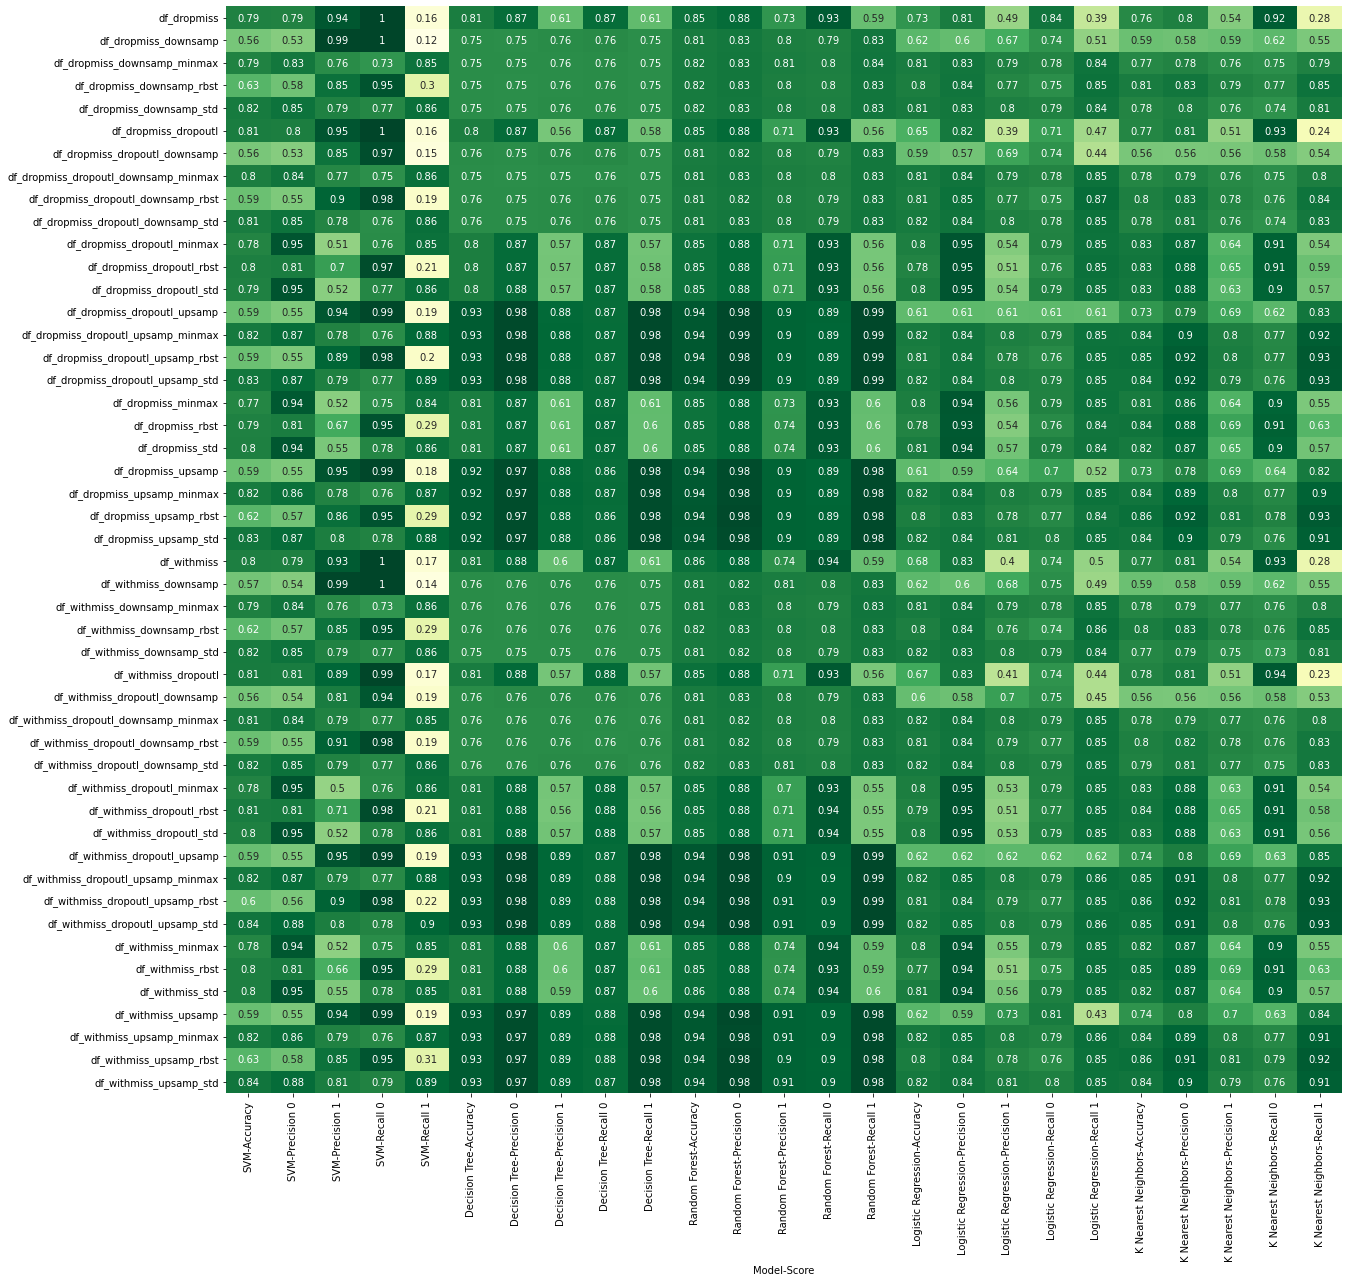

In [144]:
plt.figure(figsize=(20,20))
sns.heatmap(testing_df, annot=testing_df, cmap="YlGn", cbar=False)
plt.savefig("data/adult_dataset/general_testing_results.jpg")

In [99]:
#Define helper functions
def averageEvery5Col(row, offset: int = 0):
    total = 0.0
    count = 0
    
    current = offset
    skip = 5
    end = row.count()
    while current < end:
        total = total + row.iloc[current]
        count = count + 1
        current = current + skip
    return total / count

def getMeanDf(dataframe):
    avg_df = pd.DataFrame()
    avg_df['Mean Accuracy'] = dataframe.apply(lambda x: averageEvery5Col(x), axis=1)
    avg_df['Mean Precision 0'] = dataframe.apply(lambda x: averageEvery5Col(x,1), axis=1)
    avg_df['Mean Precision 1'] = dataframe.apply(lambda x: averageEvery5Col(x,2), axis=1)
    avg_df['Mean Recall 0'] = dataframe.apply(lambda x: averageEvery5Col(x,3), axis=1)
    avg_df['Mean Recall 1'] = dataframe.apply(lambda x: averageEvery5Col(x,4), axis=1)
    
    return avg_df

### Analyze missing value handling methods

<AxesSubplot:xlabel='Model-Score'>

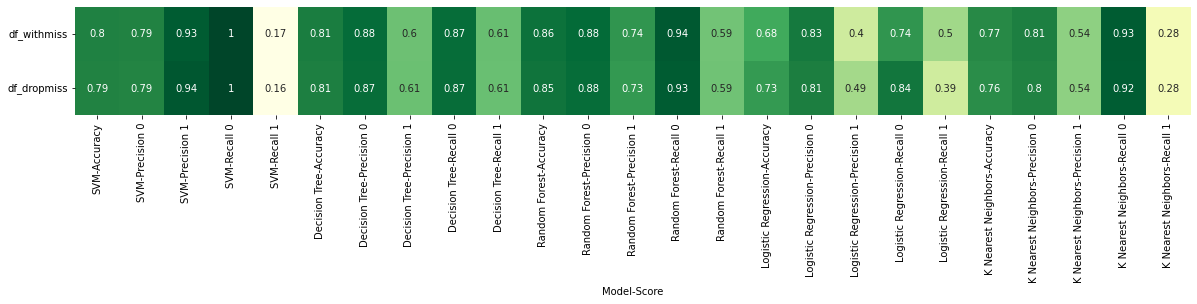

In [89]:
#Single out RAW methods
missDf = testing_df.loc[['df_withmiss','df_dropmiss']]

plt.figure(figsize=(20,2))
sns.heatmap(missDf, annot=missDf, cmap="YlGn", cbar=False)

<AxesSubplot:>

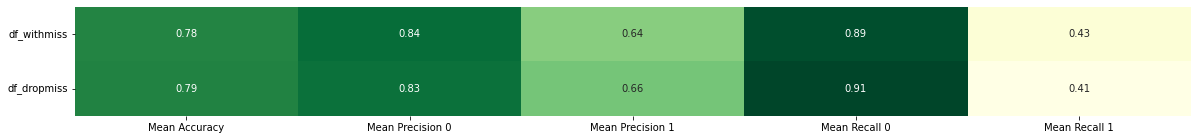

In [100]:
#Calculate mean values
avg_missDf = getMeanDf(missDf)

plt.figure(figsize=(20,2))
sns.heatmap(avg_missDf, annot=avg_missDf, cmap="YlGn", cbar=False)

Considering the average values, we will focus more on those that are related to the '1' class, as it's the less common one (before any dataset balancing has been done). We will notice that the 'df_withmiss' dataset produces better 'Recall 1' scores on average, meaning that a bigger percentage of the observations labeled as '1' have been retrieved. On the other hand, 'Precision 1' results for this dataset were a fraction lower. 

Other scores are relatively similar, even though leaning a bit towards the 'df_dropmiss' dataset, so **we will choose the method of dropping any rows with missing values**.

### Analyze extreme value handling methods

<AxesSubplot:xlabel='Model-Score'>

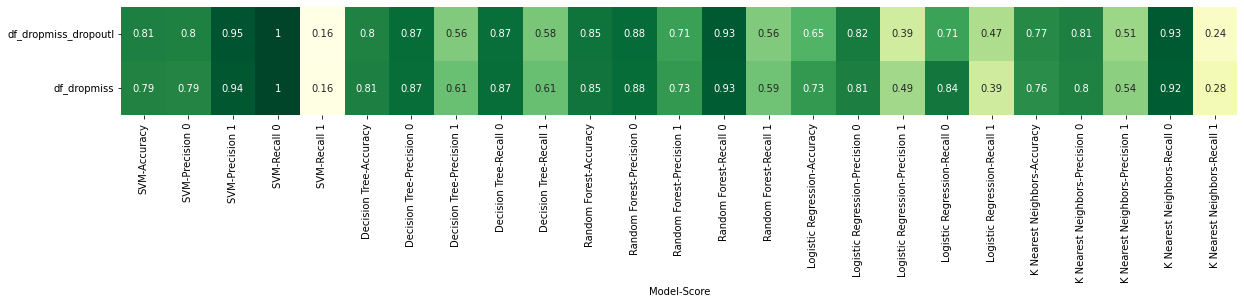

In [102]:
#Single out RAW methods
outlDf = testing_df.loc[['df_dropmiss_dropoutl','df_dropmiss']]

plt.figure(figsize=(20,2))
sns.heatmap(outlDf, annot=outlDf, cmap="YlGn", cbar=False)

<AxesSubplot:>

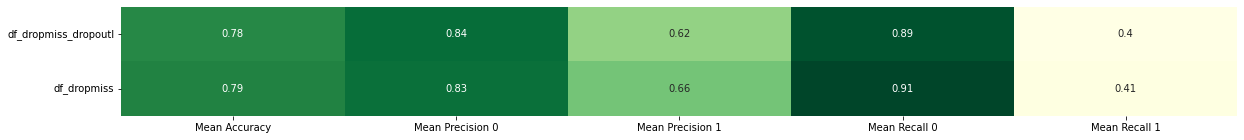

In [103]:
#Calculate mean values
avg_outlDf = getMeanDf(outlDf)

plt.figure(figsize=(20,2))
sns.heatmap(avg_outlDf, annot=avg_outlDf, cmap="YlGn", cbar=False)

Looking at individual model results, as well as mean values, it is apparent that dropping outliers leads to worse scores in most cases. The only case where there's been a noticable improvement is the 'Logistic Regression Recall 1' score.

Considering these results, **we will stick with the outliers** in further testing.

### Analyze class imbalance handling methods

<AxesSubplot:xlabel='Model-Score'>

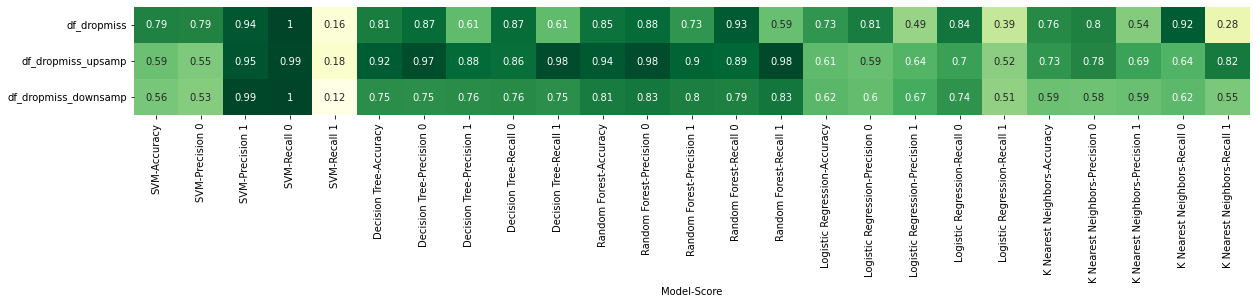

In [105]:
#Single out RAW methods
balanceDf = testing_df.loc[['df_dropmiss', 'df_dropmiss_upsamp', 'df_dropmiss_downsamp']]

plt.figure(figsize=(20,2))
sns.heatmap(balanceDf, annot=balanceDf, cmap="YlGn", cbar=False)

<AxesSubplot:>

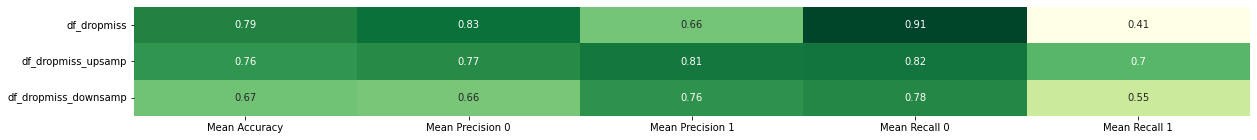

In [106]:
#Calculate mean values
avg_balanceDf = getMeanDf(balanceDf)

plt.figure(figsize=(20,2))
sns.heatmap(avg_balanceDf, annot=avg_balanceDf, cmap="YlGn", cbar=False)

Before we start talking about the results, it's important to note that each model that allowed pre-training class weight setup (every model except KNN), was setup so that class weights reflected the actual class balance of the specific dataset.

Looking at the mean and specific models, we can conclude that both forms of sampling used improve the model's ability to correctly predict '1' labeled observations, them being of the class that occurs rarely in the dataset. Sampling also degrades the model's ability to correctly predict '0' labeled observations. 

Although, through the mean values, we can see that upsampling has a bigger effect on increasing the prediction rate for the '1' class, while penalizing less the model's ability to predict the other class. Considering this, we chose **upsampling** as the method of dealing with the class imbalance.

### Analyze scaling methods

<AxesSubplot:xlabel='Model-Score'>

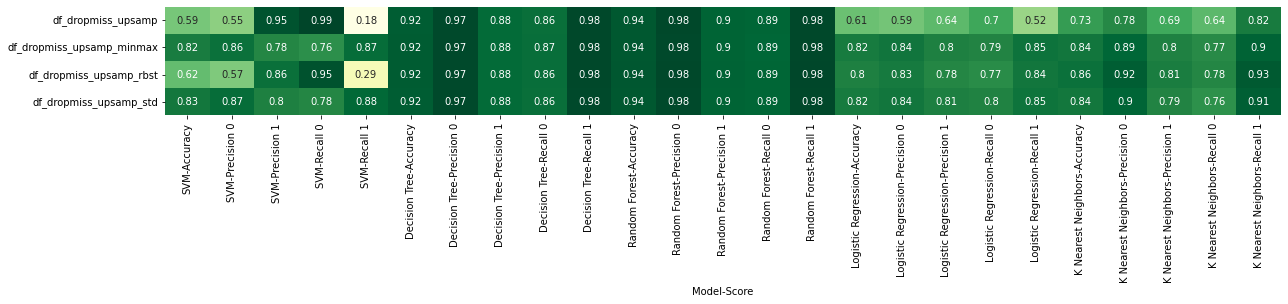

In [109]:
#Single out RAW methods
scaleDf = testing_df.loc[['df_dropmiss_upsamp', 'df_dropmiss_upsamp_minmax', 'df_dropmiss_upsamp_rbst', 'df_dropmiss_upsamp_std']]

plt.figure(figsize=(20,2))
sns.heatmap(scaleDf, annot=scaleDf, cmap="YlGn", cbar=False)

<AxesSubplot:>

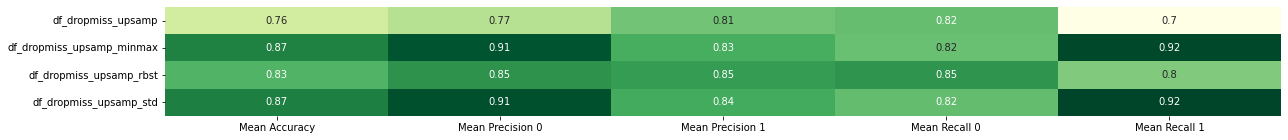

In [110]:
#Calculate mean values
avg_scaleDf = getMeanDf(scaleDf)

plt.figure(figsize=(20,2))
sns.heatmap(avg_scaleDf, annot=avg_scaleDf, cmap="YlGn", cbar=False)

Looking at the testing results, we can see that all 3 forms of scaling had a positive effect on the scores across the board, except on the RandomForest and DecisionTree models, which is to be expected, considering that they aren't generally affected by the scale of the training values. 

From the mean values, we can see that, while producing slightly higher scores for the 'Precision 1' and 'Recall 0' metrics, using the RobustScaler lead to worse results when compared to the other two scaling methods. The StandardScaler and MinMaxScaler approaches were pretty much identical when looking at the mean values, but from the detailed testing results, while we can see that both scalers produced similar results when the data was later used to train KNN and LogisticRegression models, the difference was a little bit bigger when used to train SupportVectorMachine models, in favor of the StandardScaler. 

Which is why **we decided to use the StandardScaler in further testing**. By doing that, we narrowed down the dataset choice to one dataset, that one being the **'df_dropmiss_upsamp_std'**, which will further be used to train models.

### Preprocessing actions list

In conclusion, the preprocessing that we applied to the original dataset was, in order:

1. Trimming whitespaces from the ends of any string values.
2. Removing the 'Education' column.
3. Replacing the values denoted as '?' with NaN.
4. Encoding the 'Marital Status', 'Relationship', 'Race', 'Work Class', 'Occupation', 'Native Country' columns using the OneHotEncode method.
5. Encoding the target column ('Income Class'), and the 'Sex' column with values of 0 and 1.
6. Dropping any rows containing missing values.
7. Keeping any rows containing outlier values.
8. Upsampling the minority class to reach 50/50 binary class balance.
9. Using a MinMaxScaler to scale the 'Education Num' column to preserve category ratios.
10. Using a StandardScaler to scale the 'Age', 'Final Weight', 'Capital Gain', 'Capital Loss', and 'Hours Per Week' columns.

As it's been already said, the dataset that all of this has been applied to is named **'df_dropmiss_upsamp_std'**, and will be now used in further testing.

In [69]:
#Picking the best dataset
picked_df_key = 'df_dropmiss_upsamp_std'
picked_df = dfs_touse[picked_df_key]

In [49]:
path_tosave_best = os.path.join(dirname, 'data/adult_dataset/df_dropmiss_upsamp_std.pkl')

In [139]:
#Pickling the best dataset
picked_df.to_pickle(path_tosave_best)

In [70]:
#Unpickling the best dataset
picked_df = pd.read_pickle(path_tosave_best)

## Choosing the best model

Now that we have picked one dataset, we can look at the scores each model produced after being used on the data.

<AxesSubplot:xlabel='Score', ylabel='Model'>

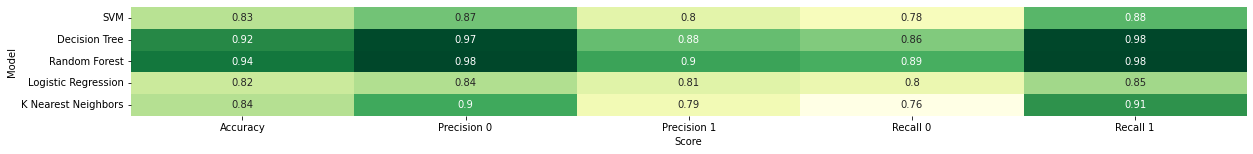

In [71]:
picked_df_results = testing_df.loc[[picked_df_key]]
picked_df_results = picked_df_results.stack().transpose()
picked_df_results.columns = picked_df_results.columns.get_level_values(1)
picked_df_results = picked_df_results.reindex(['SVM','Decision Tree','Random Forest','Logistic Regression', 'K Nearest Neighbors'])

plt.figure(figsize=(20,2))
sns.heatmap(picked_df_results, annot=picked_df_results, cmap="YlGn", cbar=False)

Here, we can see that while all 5 used models produced solid results across the board, and scoring around or over 80% on most metrics, the **'Decision Tree'** and **'Random Forest'** models produced the best results by a fairly big margin.

Hence, we will use these two models for further testing.

# Further testing

### Define functions

The way we will approach hyperparameter optimization will be through a *Grid Search* where we will cross-validate each option through stratified 10-Fold splits. We will stick to the same scoring metrics as before, and at the end of the search, we will go for those parameters that had the best 'Accuracy' score.

In [119]:
def optimize_params(X: pd.DataFrame, Y: pd.DataFrame, model, param_grid: dict):
    #Prepare cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Prepare optimization
    gridCV = GridSearchCV(model, scoring=scoring_metrics,
        param_grid=param_grid, refit='accuracy', cv=cv, n_jobs=-1)

    print(f"Optimizing hyperparameters for '{type(model)}'...")
    startTime = time.perf_counter()
    gridCV.fit(X,Y)
    endTime = time.perf_counter()
    print(f"Parameters optimized in {endTime - startTime:0.4f} seconds.")

    return gridCV.best_params_

On the other hand, the way we'll try to reduce the dimensionality of the dataset will encompass a few different methods that will be tested in parallel. First, we will try to use *Principal Component Analysis (PCA)* where the number of target components will be automatically determined using the *Minka's MLE* method. Besides that, we will test using *Recursive Feature Elimination*, where we will get results from multiple values of the target feature count, including 25%, 33%, 50%, 66%, and 75% of the original feature count. Since both Decision Tree and Random Forest models determine feature importance during training, we will attempt to use *SelectFromModel*, which will drop any features which have importance scores below the mean value. Finally, we will do univariate statistical analysis to order features by a score, after which we will use *SelectKBest* to pick a certain number of top rated features. We will test the same percentages of features as we did for *RFE*.

In [120]:
def select_features(X: pd.DataFrame, Y: pd.DataFrame, featureSelector):
    res = featureSelector.fit(X,Y)
    Xnew = X.loc[:, res.get_support()]
    return Xnew

def test_selectors(X: pd.DataFrame, Y: pd.DataFrame, model):
    selector_testing_results = {} 
    selector_results = {}
    
    noOfFeatures = [0.25,0.33,0.50,0.66,0.75]
    
    pipeline = ppline.Pipeline(steps=[('model',model)])
    
    #PCA
    label = "PCA"
    pca = PCA(n_components='mle')
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents)
    test_results = test_pipeline(pipeline, principalDf, Y, label)
    selector_testing_results[label] = test_results
    selector_results[label] = principalDf
    
    #RFE
    for no_feat in noOfFeatures:
        label = f"RFE_{no_feat}"
        rfe = RFE(model,n_features_to_select=no_feat)
        X_rfe = select_features(X, Y, rfe)
        test_results = test_pipeline(pipeline, X_rfe, Y, label)
        selector_testing_results[label] = test_results
        selector_results[label] = X_rfe
    
    #SelectFromModel
    label = f"SelectFromModel_mean"
    sfm = SelectFromModel(model, threshold='mean')
    X_sfm = select_features(X, Y, sfm)
    test_results = test_pipeline(pipeline, X_sfm, Y, label)
    selector_testing_results[label] = test_results
    selector_results[label] = X_sfm
    
    #Univariate
    for no_feat in noOfFeatures:
        label = f"Univariate_{no_feat}"
        uni = SelectKBest(mutual_info_classif, k=round(no_feat * X.shape[1]))
        X_uni = select_features(X, Y, uni)
        test_results = test_pipeline(pipeline, X_uni, Y, label)
        selector_testing_results[label] = test_results
        selector_results[label] = X_uni
        
    return (selector_testing_results, selector_results)

### Testing functions

In [121]:
def getF1Score(row, class_lab):
    prec = row[f'Precision {class_lab}']
    rec = row[f'Recall {class_lab}']
    return 2.0 * (prec*rec) / (prec+rec)

def condense_testing_results(df):
    meanAccuracy = df['Accuracy'].mean()
    mean_df = df.copy()
    mean_df['F1 0'] = df.apply(lambda x: getF1Score(x,0), axis=1)
    mean_df['F1 1'] = df.apply(lambda x: getF1Score(x,1), axis=1)
    mean_df = mean_df[mean_df['Accuracy'] > meanAccuracy]
    mean_df = mean_df.drop(['Precision 0', 'Precision 1', 'Recall 0', 'Recall 1'], axis='columns')
    mean_df = mean_df.sort_values('Accuracy', ascending=False)
    return mean_df

## Decision Tree

### Feature selection

In [122]:
X,Y = picked_df.drop('Income Class', axis=1), picked_df['Income Class']

print("Commencing Decision Tree feature selection testing....")
startTime = time.perf_counter()
decTree_results = test_selectors(X,Y,DecisionTreeClassifier())
endTime = time.perf_counter()
print(f"Decision Tree feature selection testing done in {endTime - startTime:0.4f}.")

Commencing Decision Tree feature selection testing....
Decision Tree feature selection testing done in 146.1049.


#### Analyze testing results

In [123]:
decTree_test_res, decTree_res = decTree_results

decTree_flat_test_res = {}
for key in decTree_test_res:
    decTree_flat_test_res[key] = decTree_test_res[key].values()

#Create DateFrame
decTree_feature_testing_df = pd.DataFrame.from_dict(decTree_flat_test_res, orient='index', columns=['Accuracy','Precision 0','Precision 1','Recall 0','Recall 1'])
decTree_feature_testing_df.loc['All columns'] = picked_df_results.loc['Decision Tree']
idx = decTree_feature_testing_df.index.tolist()
idx.pop(-1)
decTree_feature_testing_df = decTree_feature_testing_df.reindex(['All columns'] + idx)

<AxesSubplot:>

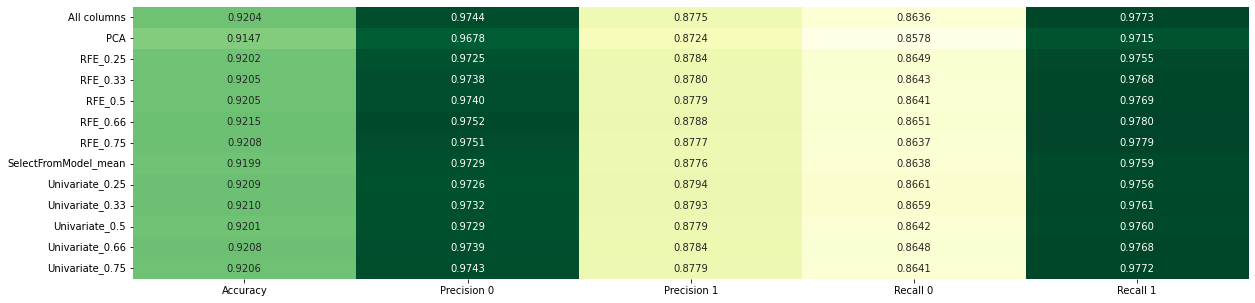

In [124]:
#Show testing results
plt.figure(figsize=(20,5))
sns.heatmap(decTree_feature_testing_df, annot=decTree_feature_testing_df, cmap="YlGn", cbar=False, fmt='.4f')

We can see that the results haven't changed much with any dimensionality reduction method, so to narrow down our choice, we will ignore any results with an 'Accuracy' score below the mean value, and we will sort them according to that score. We will also ignore the 'Recall' and 'Precision' scores, and replace them with an 'F1' score.

<AxesSubplot:>

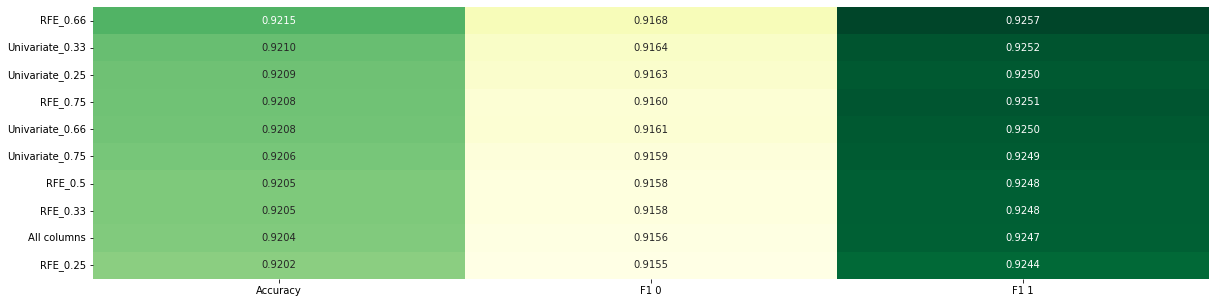

In [125]:
mean_decTree_feature_testing_df = condense_testing_results(decTree_feature_testing_df)

best_decTree_feature_selection = mean_decTree_feature_testing_df.index[0]

#Show testing results
plt.figure(figsize=(20,5))
sns.heatmap(mean_decTree_feature_testing_df, annot=mean_decTree_feature_testing_df, cmap="YlGn", cbar=False, fmt='.4f')

Now we can see that it was the **RFE 0.66** dataset that produced the best scores across the board, so it will be the one that we will use to train a 'Decision Tree' model with optimized hyperparameters.

### Hyperparameter optimization

#### Define a grid

In [126]:
decTree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [8,16,32,64,128],
    'min_samples_split': [2,4,8,16,32],
    'max_leaf_nodes': [2,4,8,16,32,64,128, None],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

#### Searching for the best parameters

In [127]:
decTree_best_X = decTree_res[best_decTree_feature_selection]
Y = picked_df['Income Class']

decTree_bestParams = optimize_params(decTree_best_X, Y, DecisionTreeClassifier(), param_grid=decTree_param_grid)

Optimizing hyperparameters for '<class 'sklearn.tree._classes.DecisionTreeClassifier'>'...
Parameters optimized in 291.5159 seconds.


In [128]:
#Display best params
print("Best params for the Decision Tree model were identified as: ", decTree_bestParams)

Best params for the Decision Tree model were identified as:  {'criterion': 'entropy', 'max_depth': 128, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_split': 2}


## Random Forest

### Feature selection

In [129]:
X,Y = picked_df.drop('Income Class', axis=1), picked_df['Income Class']

print("Commencing Random Forest feature selection testing....")
startTime = time.perf_counter()
randFor_results = test_selectors(X,Y,RandomForestClassifier())
endTime = time.perf_counter()
print(f"Random Forest feature selection testing done in {endTime - startTime:0.4f}.")

Commencing Random Forest feature selection testing....
Random Forest feature selection testing done in 993.9842.


#### Analyze testing results

In [130]:
randFor_test_res, randFor_res = randFor_results

randFor_flat_test_res = {}
for key in randFor_test_res:
    randFor_flat_test_res[key] = randFor_test_res[key].values()

#Create DateFrame
randFor_feature_testing_df = pd.DataFrame.from_dict(randFor_flat_test_res, orient='index', columns=['Accuracy','Precision 0','Precision 1','Recall 0','Recall 1'])
randFor_feature_testing_df.loc['All columns'] = picked_df_results.loc['Random Forest']
idx = randFor_feature_testing_df.index.tolist()
idx.pop(-1)
randFor_feature_testing_df = randFor_feature_testing_df.reindex(['All columns'] + idx)

<AxesSubplot:>

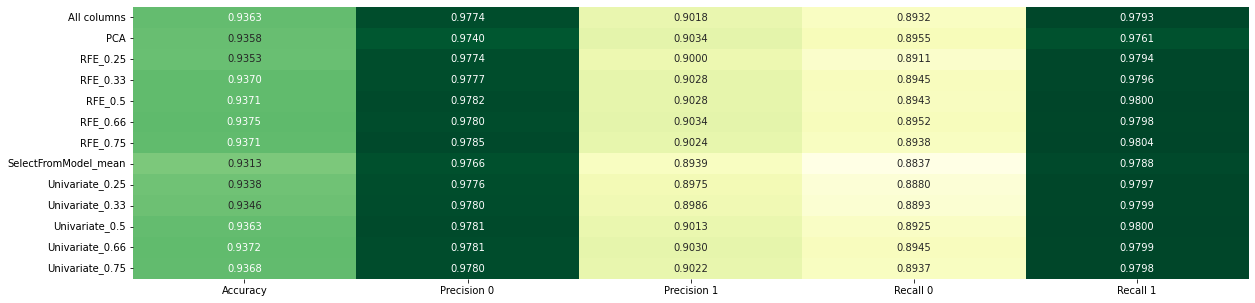

In [131]:
#Show testing results
plt.figure(figsize=(20,5))
sns.heatmap(randFor_feature_testing_df, annot=randFor_feature_testing_df, cmap="YlGn", cbar=False, fmt='.4f')

Again, we can see that the results haven't changed much with any dimensionality reduction method, so to narrow down our choice, we will apply the same transformation to the testing scores as we did with the 'Decision Tree' testing results.

<AxesSubplot:>

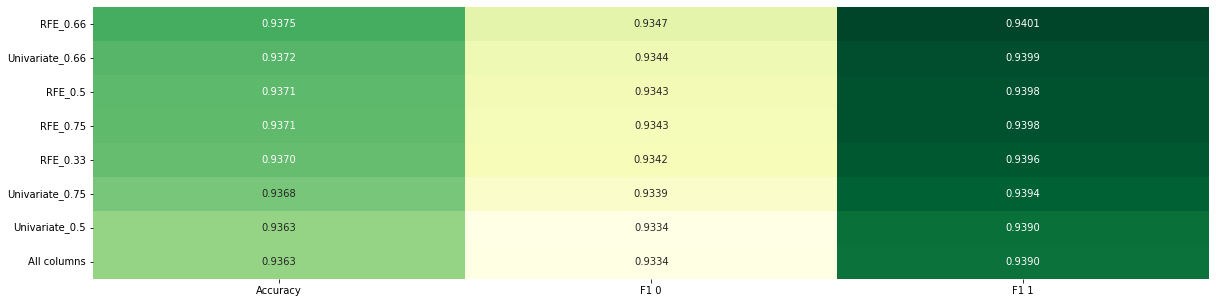

In [132]:
mean_randFor_feature_testing_df = condense_testing_results(randFor_feature_testing_df)

best_randFor_feature_selection = mean_randFor_feature_testing_df.index[0]

#Show testing results
plt.figure(figsize=(20,5))
sns.heatmap(mean_randFor_feature_testing_df, annot=mean_randFor_feature_testing_df, cmap="YlGn", cbar=False, fmt='.4f')

In this case, it was the **RFE 0.66** dataset that produced the best scores across the board, so it will be the one that we will use to train a 'Random Forest' model with optimized hyperparameters.

### Hyperparameter optimization

#### Define a grid

In [137]:
randFor_param_grid = {
    'n_estimators': [50,100,150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,20,50,None],
    'min_samples_split': [2,3,4,5],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

#### Searching for the best parameters

In [138]:
randFor_best_X = randFor_res[best_randFor_feature_selection]
Y = picked_df['Income Class']

randFor_bestParams = optimize_params(randFor_best_X, Y, RandomForestClassifier(), param_grid=randFor_param_grid)

Optimizing hyperparameters for '<class 'sklearn.ensemble._forest.RandomForestClassifier'>'...
Parameters optimized in 4700.2128 seconds.


In [139]:
#Display best params
print("Best params for the Random Forest model were identified as: ", randFor_bestParams)

Best params for the Random Forest model were identified as:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


## Analyze final testing results

### Best Decision Tree estimator

In [140]:
decTree_pipeline = ppline.Pipeline([('model', DecisionTreeClassifier(**decTree_bestParams))])

decTree_best_results = test_pipeline(decTree_pipeline, decTree_best_X, Y, "Best Decision Tree", printRes=True)

Performance results: Best Decision Tree
Accuracy: 91.950%
Precision for class 0: 97.059%
Precision for class 1: 87.852%
Recall for class 0: 86.523%
Recall for class 1: 97.377%


### Best Random Forest estimator

In [141]:
randFor_pipeline = ppline.Pipeline([('model', RandomForestClassifier(**randFor_bestParams))])

randFor_best_results = test_pipeline(randFor_pipeline, randFor_best_X, Y, "Best Random Forest", printRes=True)

Performance results: Best Random Forest
Accuracy: 93.600%
Precision for class 0: 97.782%
Precision for class 1: 90.106%
Recall for class 0: 89.225%
Recall for class 1: 97.975%


### Results

<AxesSubplot:>

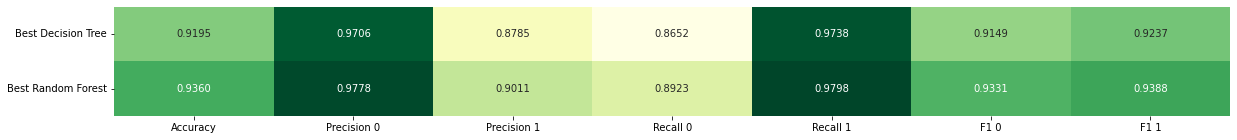

In [142]:
total_results = {}
total_results["Best Decision Tree"] = decTree_best_results.values()
total_results["Best Random Forest"] = randFor_best_results.values()

total_results_df = pd.DataFrame.from_dict(total_results, orient='index', columns=['Accuracy','Precision 0','Precision 1','Recall 0','Recall 1'])
dump_copy = total_results_df.copy()
total_results_df['F1 0'] = dump_copy.apply(lambda x: getF1Score(x,0), axis=1)
total_results_df['F1 1'] = dump_copy.apply(lambda x: getF1Score(x,1), axis=1)

#Show testing results
plt.figure(figsize=(20,2))
sns.heatmap(total_results_df, annot=total_results_df, cmap="YlGn", cbar=False, fmt='.4f')